In [1]:
import sys
import pathlib
import os
from nltk.stem.snowball import SpanishStemmer
import re

In [2]:
MIN_LENGTH = 2
MAX_LENGTH = 25
stemming_enabled = True
in_file = "quijote.txt"
palabras_vacias = []

Definimos algunas funciones para normalizar las cadenas. Tomamos como base los programas anteriores, eliminando signos de puntuación, tildes y pasando a minúsculas.  

In [3]:
def remove_punctuation(token):
    return re.sub("\W", "", token)

def translate(to_translate):
    tabin = u'áäâàãéëèêẽíïĩìîóõöòôúüùûũ'
    tabout = u'aaaaaeeeeeiiiiiooooouuuuu'
    tabin = [ord(char) for char in tabin]
    translate_table = dict(zip(tabin, tabout))
    return to_translate.translate(translate_table)

def normalize(token):
    result = token.lower()
    result = translate(result)       
    return result

In [4]:
frequencies = {}
total_tokens  = 0
total_terms = 0

if stemming_enabled:
    stemmer = SpanishStemmer()

with open(in_file, "r", encoding="utf-8") as f:
    for line in f.readlines():
        tokens_list = [remove_punctuation(normalize(x)) for x in line.strip().split()]

        for token in tokens_list:                                     
            total_tokens += 1
            if token not in palabras_vacias and len(token) >= MIN_LENGTH and len(token) <= MAX_LENGTH:
                if stemming_enabled:
                    token = stemmer.stem(token)
                if token in frequencies.keys():
                    frequencies[token] += 1
                else: # Si es la primera vez que veo este token, se agrega a los términos en 1
                    frequencies[token] = 1         
                    total_terms += 1                    

In [5]:
sorted_dict = dict(sorted(frequencies.items(), key=lambda item: item[1], reverse=True))

Dentro de un diccionario almacenamos los términos y la fecuencia de cada uno. Luego lo ordenamos de mayor a menor por la misma.

A continuación, hacemos una transformación a escala logarítmica y calculamos una recta de ajuste:

In [23]:
import numpy as np

x = list(range(1,len(sorted_dict)+1))
y = list(sorted_dict.values())

x_log = np.log(x)
y_log = np.log(y)

In [24]:
ajuste = np.polyfit(list(x_log), y_log, 1)
recta = np.poly1d(ajuste)

In [25]:
y_log_pred = x_log*recta[1] + recta[0]

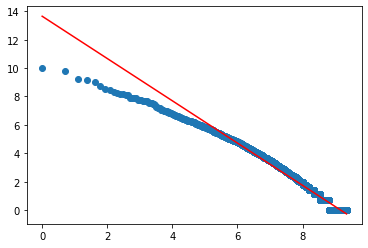

In [46]:
import matplotlib.pyplot as plt
plt.scatter(x_log, y_log)
plt.plot(x_log, y_log_pred, color="red")
plt.show()

Ahora mantenemos la escala original, y calculamos una curva de ajuste para esta. 

In [37]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a*(x**b)

popt, pcov = curve_fit(func, x, y)
y_pred = func(x, *popt)

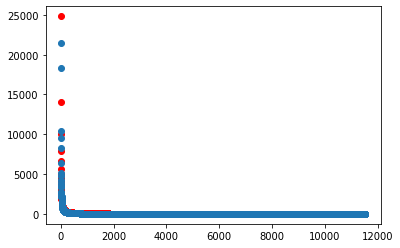

In [39]:
plt.scatter(x, y_pred, color="red")
plt.scatter(x,y)
plt.show()

En el gráfico anterior vemos en rojo los puntos del ajuste, y en azul los puntos de la distribución original.

Medimos ahora la correlación entre los puntos en ambas escalas, para comprobar cómo se comporta la predicción.

In [42]:
np.corrcoef(y, y_pred)

array([[1.        , 0.98564441],
       [0.98564441, 1.        ]])

In [44]:
np.corrcoef(y_log, y_log_pred)

array([[1.        , 0.98757155],
       [0.98757155, 1.        ]])

Como podemos observar, el coeficiente de correlación entre la predicción y los valores reales es muy alto. Si bien esto se ve gráficamente, al plotearlo perdemos de vista la cantidad de observaciones, debido al solapamiento de los puntos. Sobre la izquierda de los gráficos hay una diferencia notoria entre la predicción y los valores reales, correspondiéndose a aquellos términos con mayor frecuencia. Sin embargo, son poco numerosos, y a partir de allí comienza la mayor concentración de observaciones entre las que se presenta tal similitud.

En principio, este experimento nos sirve para verificar el cumplimiento de la Ley de Zipf, dado que al realizar el ajuste tomamos como función de ajuste a la planteada en la power law. Con esto, obtuvimos los coeficientes de la ecucación, y al calcularla para la distribución original (los rankings), obtuvimos los valores ajustados a ella. Dado que al comparar la correlación con la frecuencia de la distribución original el coeficiente fue tan alto, los resultados coinciden con los enunciados de referencia.
